In [24]:
# IMPORTS

import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
import lightkurve as lk

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import astropy
from astropy.timeseries import TimeSeries


In [25]:
# FOLDERS AND DIRECTORIES

lc_train_folder = "./lightcurvePLOTS/" # create one for lightcurves with no exoplanets
lc_train_dir = os.listdir(lc_train_folder)
lc_exo_plots = "./lightcurvePLOTS/has_exoplanets/"
lc_fa_plots = "./lightcurvePLOTS/no_exoplanets/" # false alarms

In [26]:
# PHASE AND BIN FUNCTION

def phase_and_bin(data,period,t0,bin_time):
    data_phased = data.fold(period=period,epoch_time=t0)
    data_binned = data_phased.bin(bin_time)
    return data_binned


In [27]:
# PLOT AND SAVE FUNCTION

def plot_and_save(pltdata,path,name,num):
    pltdata.plot(linewidth=0,marker=".")
    plt.savefig(os.path.abspath(path) + name + str(num) + ".png")
    plt.show()
    return

TIC 72437047


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


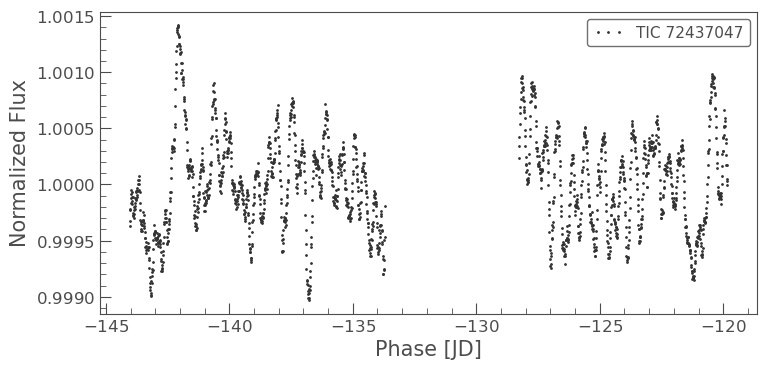

TIC 72437047
TIC 230061010
TIC 230061010
TIC 230061010


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


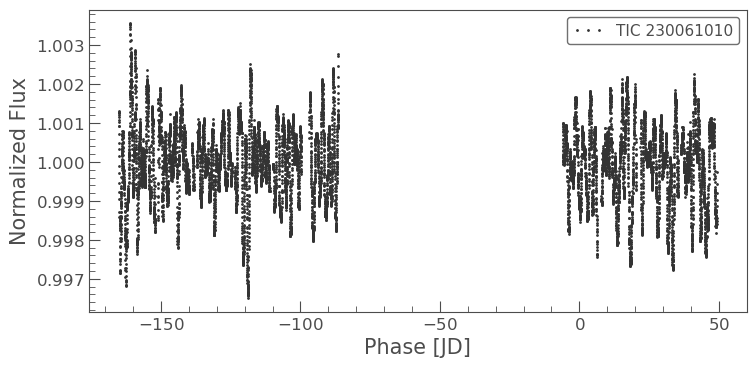

TIC 333225860
TIC 333225860


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


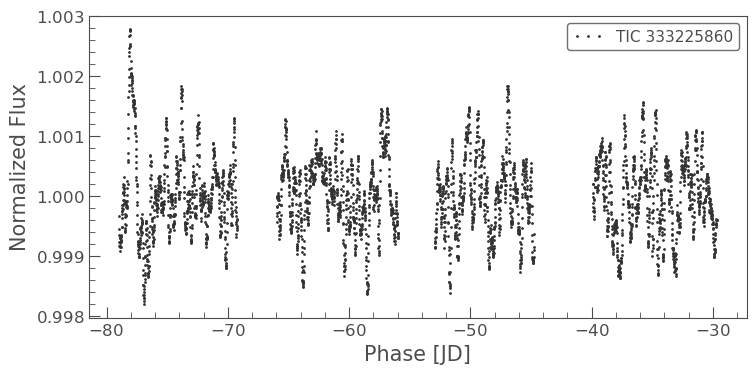

TIC 219483057
TIC 219483057


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


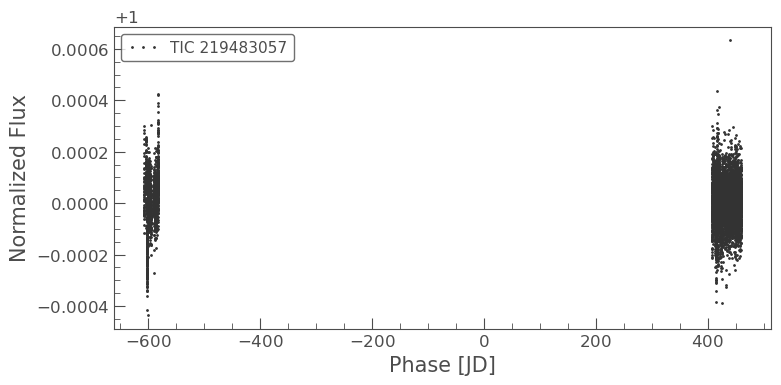

TIC 219483057
TIC 219483057
TIC 219483057


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


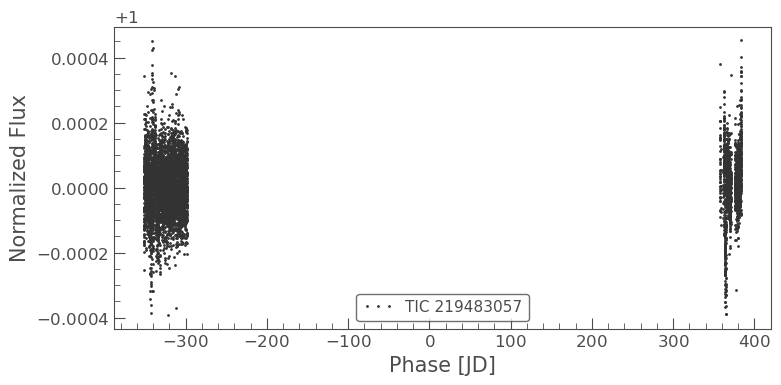

TIC 219483057
TIC 219483057


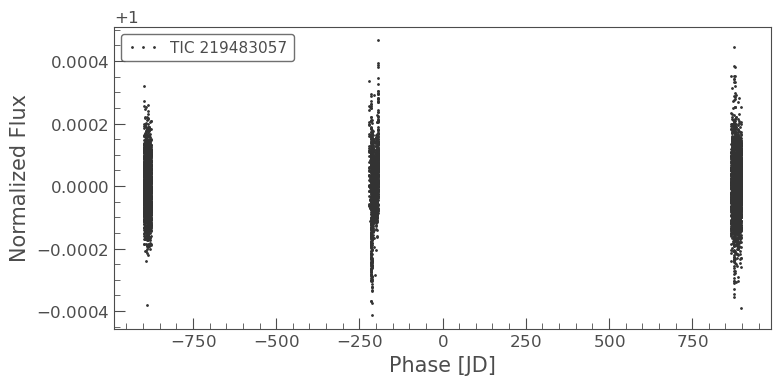

TIC 27533327


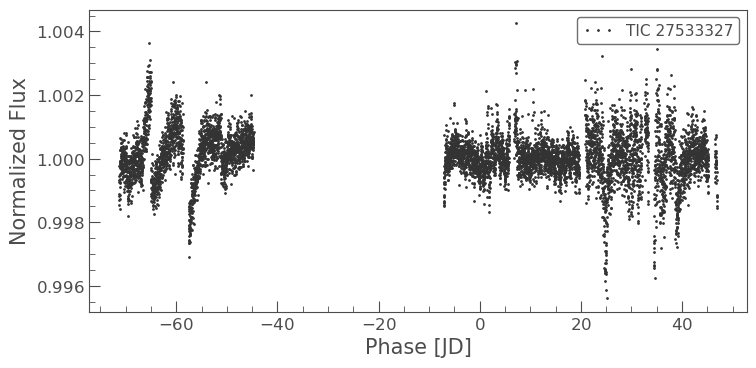

TIC 27533327
TIC 27533327


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


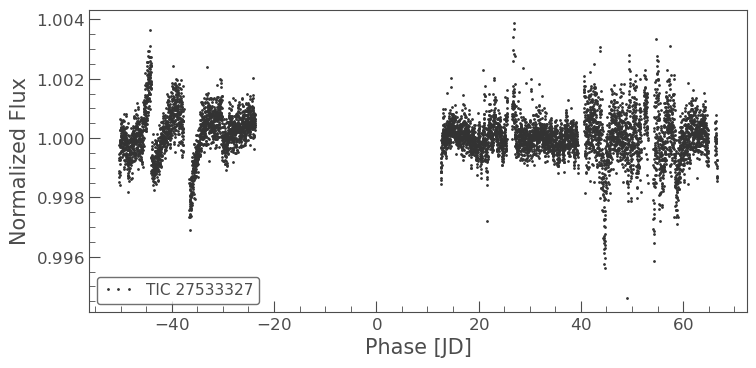

TIC 27533327


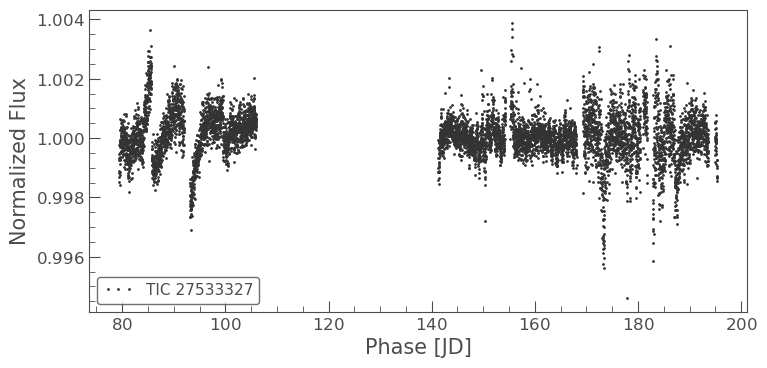

TIC 27533327
TIC 27533327


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


KeyboardInterrupt: 

In [33]:
# FETCH DATA (TESS DATA W/ LIGHTKURVE)

exonames_tbl = pd.read_csv(os.path.abspath("PS_2022.06.27_08.12.38.csv"),delimiter=",",comment="#")
TICs = exonames_tbl["tic_id"]
periods = exonames_tbl["pl_orbper"] # for phasing
epochs = exonames_tbl["pl_orbtper"] # for phasing

bintime = 15/24/60


for x in range(0,17):
    print(TICs[x])
    name = TICs[x]
    if np.isnan(periods[x]) == False and np.isnan(epochs[x]) == False:
        train_exo_search = lk.search_lightcurve(str(name),author="SPOC")[0:5]
        lc_exo_train = train_exo_search.download_all().stitch()
        
        lc_exo_train_binned = phase_and_bin(lc_exo_train,periods[x],epochs[x],bintime)
        
        plot_and_save(lc_exo_train_binned,lc_exo_plots,"/lc_exo_trainplots_",x)

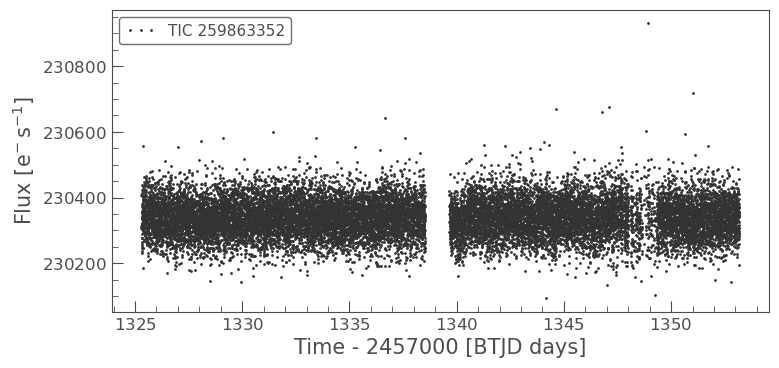

/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.


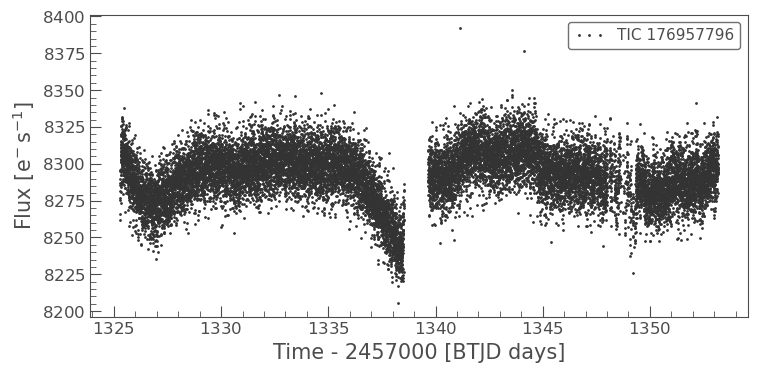

/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.
No lightcurve found.


No data found for target "TIC 459903429".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 310981412".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 237108272".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 341815767".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 41173048".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


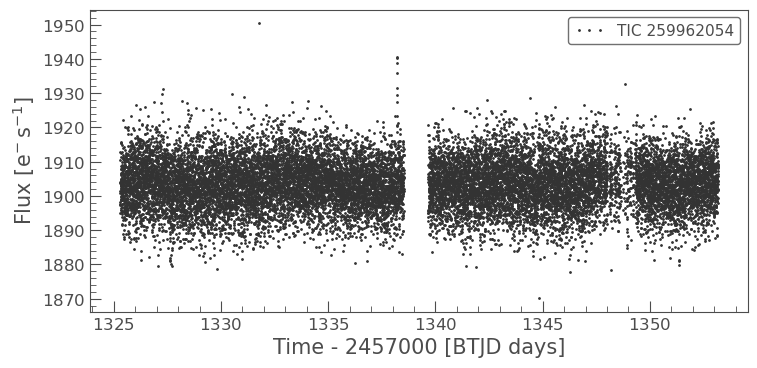

No data found for target "TIC 159244568".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 394029948".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 75656058".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 326453034".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 100504381".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 376168473".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 441798995".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 160074939".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 321068176".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


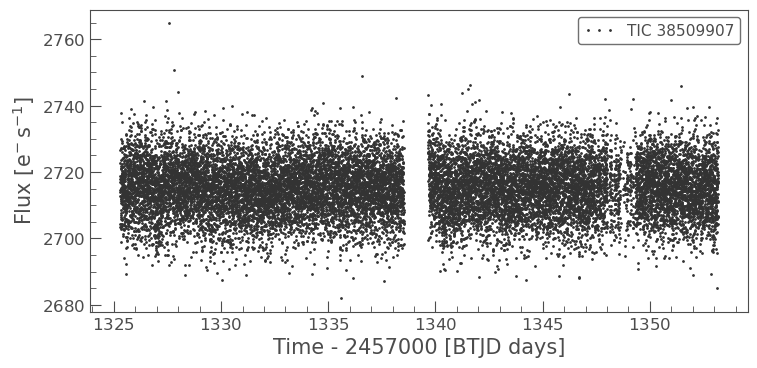

No data found for target "TIC 49687222".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 234282389".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


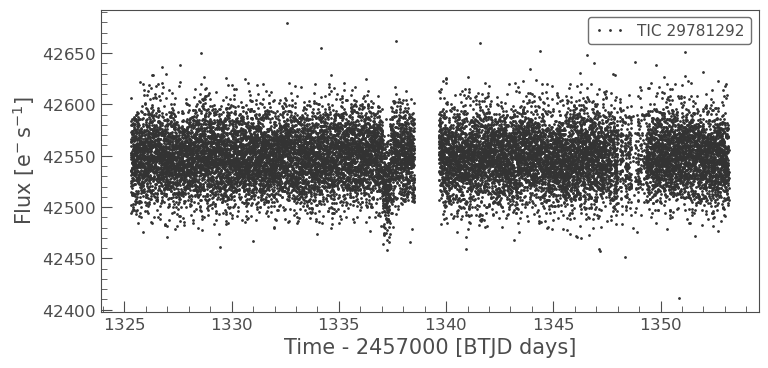

No data found for target "TIC 233831759".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 87597187".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 71134735".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 8677530".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 55748194".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 68035558".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 20303110".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 452972453".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 390048041".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 10974783".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 224601047".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 229976631".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 459952217".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 143022742".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.
No lightcurve found.


No data found for target "TIC 62301521".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 376981340".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 103604037".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 93125144".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 365690646".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 161477033".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 344926234".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 286132427".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 78154865".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 320417762".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 458589703".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 150151262".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 150247134".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 219401954".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


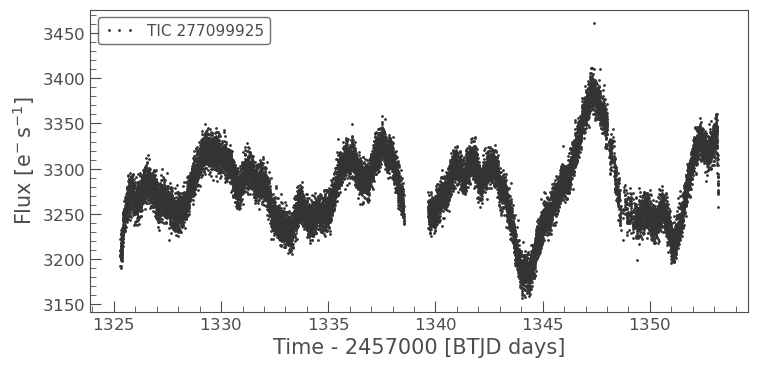

No data found for target "TIC 125405602".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


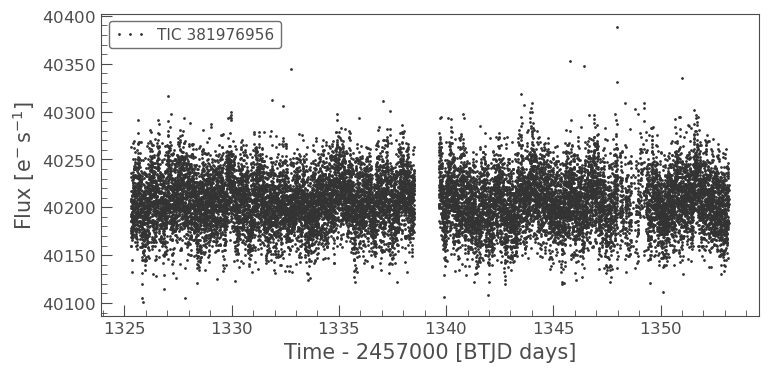

No data found for target "TIC 200807066".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 219380235".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 102283403".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


No lightcurve found.


No data found for target "TIC 245947683".


No lightcurve found.


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


In [39]:
fa_tbl = pd.read_csv(os.path.abspath("TOI_2022.06.29_08.07.35.csv"),delimiter=",",comment="#")
fa_TICs = fa_tbl["tid"]

y = 0

while y < len(fa_TICs):
    name1 = fa_TICs[y]
    try:
        train_fa_search = lk.search_lightcurve("TIC " + str(name1),author="SPOC",sector=1)
        lc_fa_train = train_fa_search.download()
        plot_and_save(lc_fa_train,lc_fa_plots,"/lc_fa_trainplots_",y)
    except:
        train_fa_search = lk.search_lightcurve("TIC " + str(name1),author="TESS",sector=1)
        lc_fa_train = train_fa_search.download()
        plot_and_save(lc_fa_train,lc_fa_plots,"/lc_fa_trainplots_",y)
    else:
        print("No lightcurve found.")
    
    y = y + 1

In [40]:
# USER INPUT TARGET STAR AND MISSION

target = str(input("Enter your target: "))
mission = str(input("Enter mission: "))
quart = input("Enter quarter (Kepler) or sector (TESS), A for all, M for multiple: ")

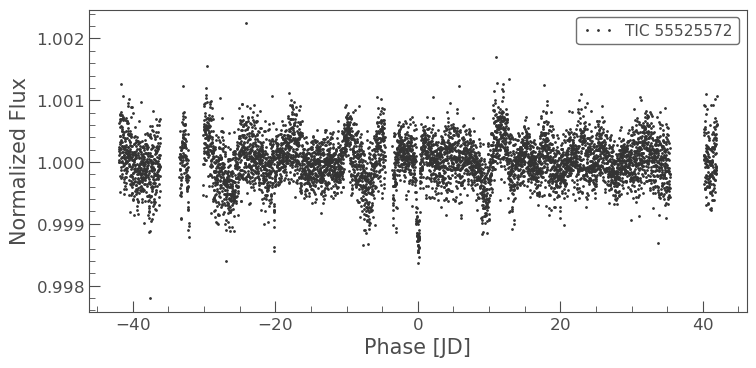

In [41]:
# FIND, PLOT AND SAVE TEST DATA

test_plot_dir = "./testPLOTS/"

if quart == "A" or quart == "a" or quart == "all" or quart == "All":
    testsearch = lk.search_lightcurve(target,author=mission)
    lc_test = testsearch.download()

elif quart == "M":
    q1 = int(input("Enter first quarter/sector: "))
    q2 = int(input("Enter last quarter/sector: "))
    testsearch = lk.search_lightcurve(target,author=mission)[q1:q2]
    lc_test = testsearch.download_all().stitch()

else:
    if mission == "Kepler":
        testsearch = lk.search_lightcurve(target,author=mission,quarter=int(quart))
    elif mission == "SPOC":
        testsearch = lk.search_lightcurve(target,author=mission,sector=int(quart))
    lc_test = testsearch.download()

period = 83.8979
t0 = 2125.847

lc_test_binned = phase_and_bin(lc_test,period,t0,bintime)

plot_and_save(lc_test_binned,test_plot_dir,"/lc_testplot.png",0)

Found 14 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Epoch 1/10
250/250 [==============================] - 1s 922us/step - loss: 1.2461 - accuracy: 0.4286 - val_loss: 0.7477 - val_accuracy: 0.5000
[[1.]]


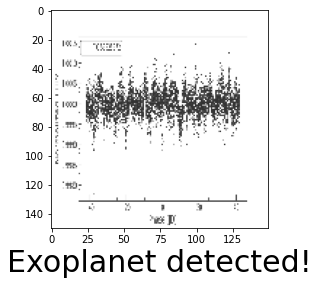

In [46]:
# CREATE TRAIN AND TEST DATASETS

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)
batchsize = 7
trainplots = "./lightcurvePLOTS/"

train_ds = train.flow_from_directory(
    os.path.abspath(trainplots),
    target_size=(150,150),
    batch_size = batchsize,
    class_mode = 'binary')

test_ds = test.flow_from_directory(
    os.path.abspath(test_plot_dir),
    target_size=(150,150),
    batch_size = batchsize,
    class_mode = 'binary')

# BUILD CNN MODEL

model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512,activation="relu"))

model.add(keras.layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# TRAIN DATA

model.fit(
    train_ds,
    steps_per_epoch = 250,
    epochs = 10,
    validation_data = test_ds
)

# PREDICTIONS (FUNCTION)

def predictExo(filename):
    img = image.load_img(filename,target_size=(150,150))
    plt.imshow(img)

    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)

    val = model.predict(X)
    print(val)

    if val == 1:
        plt.xlabel("Exoplanet detected!",fontsize=30)
    elif val == 0:
        plt.xlabel("No exoplanet detected.",fontsize=30)

predictExo(os.path.join(os.path.abspath(test_plot_dir),"valid_exoplanets","lc_testplot.png"))